In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
import numpy as np

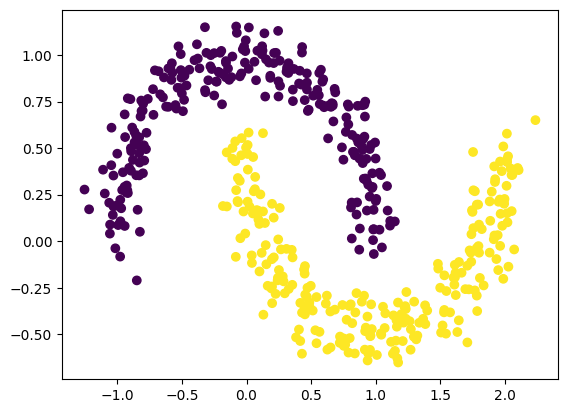

In [71]:
X, y = make_moons(n_samples=500, noise=0.1)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [72]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [73]:
model = SimpleNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

for epoch in range(1000):
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.6512978076934814
Epoch 100, Loss: 0.2311965525150299
Epoch 200, Loss: 0.14678476750850677
Epoch 300, Loss: 0.06410524994134903
Epoch 400, Loss: 0.0338631272315979
Epoch 500, Loss: 0.02147466316819191
Epoch 600, Loss: 0.015234082005918026
Epoch 700, Loss: 0.011601509526371956
Epoch 800, Loss: 0.009250643663108349
Epoch 900, Loss: 0.007614587899297476


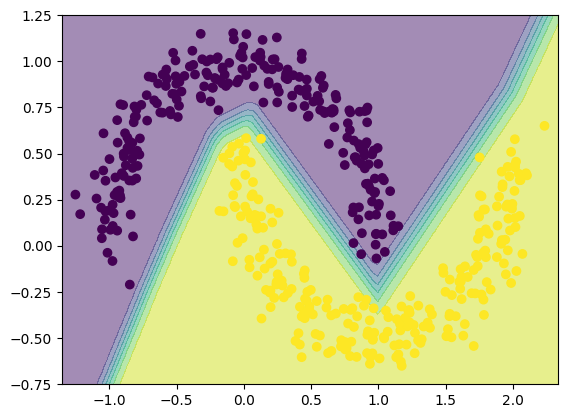

In [74]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    probs = model(grid).detach().numpy().reshape(xx.shape)

    plt.contourf(xx, yy, probs, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

plot_decision_boundary(model, X, y)

----

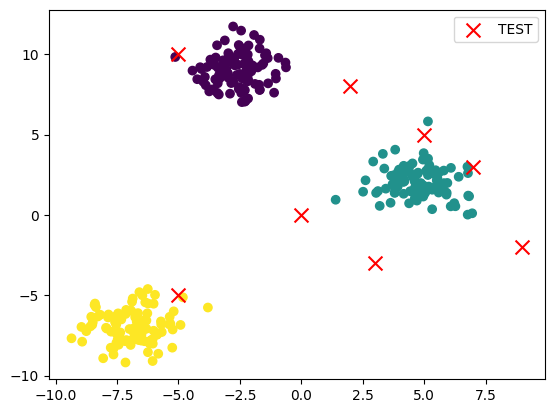

In [75]:
# Dane treningowe (3 klastry)
X, y = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

# Dane testowe - trochę dziwne, trochę z boku
X_test = np.array([
    [0, 0], 
    [5,5],
    [3,-3],
    [-5,10],
    [7, 3], 
    [-5, -5],
    [2, 8],
    [9, -2]
])

# Klasy są nieznane → model ma zgadnąć

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='x', s=100, label='TEST')
plt.legend()
plt.show()

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [77]:
class BlobNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 3)  # 3 klasy
        )

    def forward(self, x):
        return self.model(x)

In [78]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


In [79]:
model = BlobNet()
criterion = nn.CrossEntropyLoss()  # multi-class
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [80]:
epochs = 1000
train_losses = []

for epoch in range(epochs):
    model.train()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Epoch 0, Loss: 1.0005
Epoch 100, Loss: 0.0001
Epoch 200, Loss: 0.0001
Epoch 300, Loss: 0.0001
Epoch 400, Loss: 0.0000
Epoch 500, Loss: 0.0000
Epoch 600, Loss: 0.0000
Epoch 700, Loss: 0.0000
Epoch 800, Loss: 0.0000
Epoch 900, Loss: 0.0000


In [81]:
with torch.no_grad():
    y_val_pred = model(X_val_tensor)
    val_preds = torch.argmax(y_val_pred, axis=1)
    val_acc = (val_preds == y_val_tensor).float().mean()
    print(f'Validation accuracy: {val_acc:.2f}')


Validation accuracy: 1.00


In [82]:
import torch.nn.functional as F


model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    predicted_classes = torch.argmax(F.softmax(y_test_pred, dim=1), axis=1)
    print('Predykcje test setu:', predicted_classes.numpy())


Predykcje test setu: [1 1 1 0 1 2 1 1]


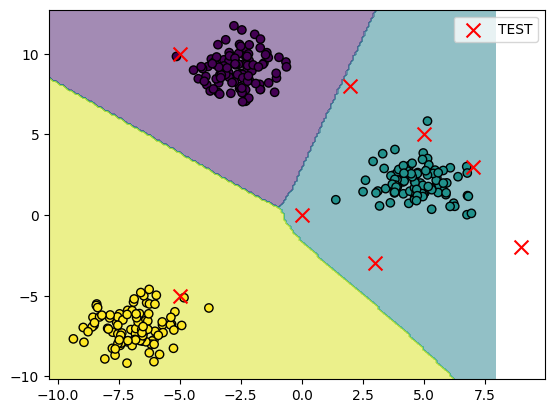

In [83]:
def plot_decision_boundary(model, X, y, X_test=None):
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    probs = model(grid).detach()
    preds = torch.argmax(F.softmax(probs, dim=1), axis=1).numpy().reshape(xx.shape)

    plt.contourf(xx, yy, preds, alpha=0.5, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
    if X_test is not None:
        plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='x', s=100, label='TEST')
        plt.legend()
    plt.show()

plot_decision_boundary(model, X, y, X_test)


<Axes: >

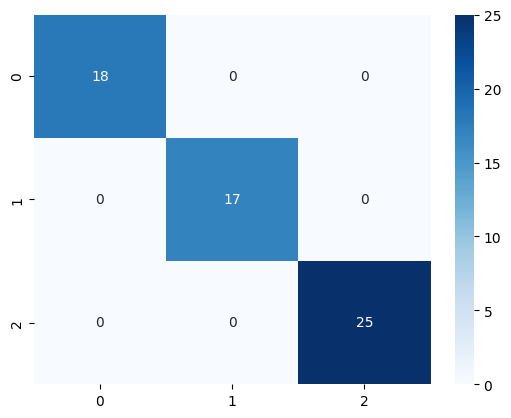

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val_tensor, val_preds)
sns.heatmap(cm, annot=True, cmap="Blues")


In [ ]:
# torch.save(model.state_dict(), 'model.pth')
